In [110]:
!pip install -q MRdataset
!pip install -q mrQA
!pip install -q seaborn matplotlib
import IPython

In [1]:
""" 
# To import datasets using S3Path and S3Client. Otherwise, only provide path to your local directory in data_root 

from cloudpathlib import S3Path, S3Client

def get_jsons(path):
    if path.is_dir():
        if path.name != 'derivatives' and path.name != 'sourcedata':
            for p in path.iterdir():
                yield from get_jsons(p)
    elif path.name.endswith('.json'):
        yield path

download_path = '/home/jovyan/openneuro'
        
jsons = []
for ds in ['ds004215', 'ds002785']:
    base_path = S3Path(
        f's3://openneuro.org/{ds}/',
        client=S3Client(
            no_sign_request=True,
            local_cache_dir=download_path))
    for json in get_jsons(base_path):
        jsons.append(json.fspath)
"""

" \nfrom cloudpathlib import S3Path, S3Client\n\ndef get_jsons(path):\n    if path.is_dir():\n        if path.name != 'derivatives':\n            for p in path.iterdir():\n                yield from get_jsons(p)\n    elif path.name.endswith('.json'):\n        yield path\n\ndownload_path = '/home/jovyan/openneuro'\n        \njsons = []\nfor ds in ['ds004215', 'ds002785']:\n    base_path = S3Path(\n        f's3://openneuro.org/{ds}/',\n        client=S3Client(\n            no_sign_request=True,\n            local_cache_dir=download_path))\n    for json in get_jsons(base_path):\n        jsons.append(json.fspath)\n"

In [111]:
from MRdataset import import_dataset

data_root = '/home/jovyan/shared/ds000030' #change path here /home/jovyan/openneuro/openneuro.org/ds004215
output_dir = '/home/jovyan/my_project/mr_reports/ds000030' #change path here

In [38]:
# import os
# os.chdir('/home/jovyan/shared/ds003688')
# os.getcwd()

In [112]:
# Runs the dataset
dataset = import_dataset(data_source=data_root,
                         ds_format='bids',
                         name='ds000032')

In [113]:
print(dataset)

FastBIDSDataset ds000032 with 10 Modality


In [114]:
for modality in dataset.modalities:
    print(modality)

Modality anat_T1w with 265 Subject
Modality dwi_dwi with 262 Subject
Modality func_task-bart_bold with 263 Subject
Modality func_task-bht_bold with 258 Subject
Modality func_task-pamenc_bold with 207 Subject
Modality func_task-pamret_bold with 208 Subject
Modality func_task-rest_bold with 268 Subject
Modality func_task-scap_bold with 268 Subject
Modality func_task-stopsignal_bold with 266 Subject
Modality func_task-taskswitch_bold with 266 Subject


In [12]:
# for modality in dataset.modalities:
    # print(modality)
    # for subject in modality.subjects:
        # print(subject)
    # print("\n")

In [115]:
# Run check compliance tool

from mrQA import check_compliance
check_compliance(dataset=dataset, output_dir=output_dir, tolerance = 0.05)

In ds000032 dataset, modalities "anat_T1w, dwi_dwi, func_task-bart_bold, func_task-bht_bold, func_task-pamenc_bold, func_task-pamret_bold, func_task-rest_bold, func_task-scap_bold, func_task-stopsignal_bold, func_task-taskswitch_bold" are non-compliant. See /home/jovyan/my_project/mr_reports/ds000030/ds000032_DATE_08_16_2023_18_58_00.html for report


PosixPath('/home/jovyan/my_project/mr_reports/ds000030/ds000032_DATE_08_16_2023_18_58_00.html')

In [116]:
# We need to organize parameters in a dictionary (by modality) to extracte the numeric values
import re
mod_params={}
re_pattern_mod = r"Modality "
re_pattern_sub = r" with [0-9]+ Subject"

for modality in dataset.modalities:
    #use regex to strip parts of the string in the modality that's not the modality name
    mod_name=str(modality)
    mod_name = re.sub(re_pattern_mod , "", mod_name)
    mod_name = re.sub(re_pattern_sub , "", mod_name)
    
    mod_params[mod_name] = {} 
    params_dict = {}
    for subject in modality.subjects:
        for session in subject.sessions:
            for run in session.runs:
                for key, value in run.params.items():
                    if key not in params_dict:
                        params_dict[key] = []
                    params_dict[key].append(value)
    mod_params[mod_name] = params_dict

In [117]:
import pandas as pd

# Start with an empty list to accumulate rows
data_rows = []

for modality, params in mod_params.items():
    for param, values in params.items():
        for value in values:
            # Create a row for each value
            data_row = {'Modality': modality, 'Parameter': param, 'Value': value}
            data_rows.append(data_row)

# Convert the list of rows into a DataFrame
df = pd.DataFrame(data_rows)
#print(df)

In [118]:
# Make sure the Value column is numeric for visualization purposes
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

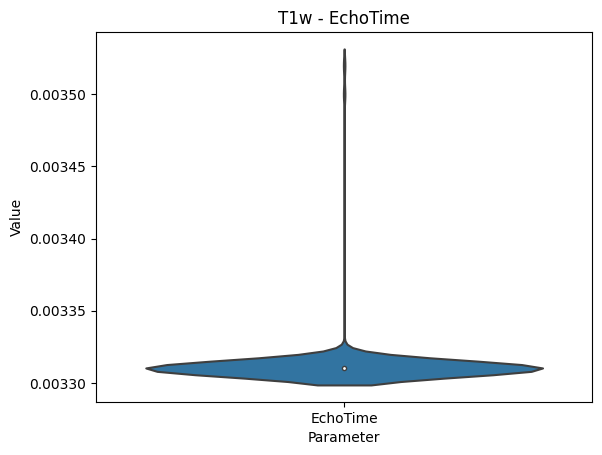

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the data
subset_df = df[(df['Modality'] == 'anat_T1w') & (df['Parameter'] == 'EchoTime')]

# Plot using seaborn
sns.violinplot(data=subset_df, x='Parameter', y='Value')
plt.title("T1w - EchoTime")
plt.show()

In [120]:
df.to_csv('output_data.csv', index=False)

In [48]:
"""
import pandas as pd

html = '/home/jovyan/my_project/mr_reports/ds000030_DATE_08_15_2023_17_14_54.html'
csv = 'my_file.csv'

# 1. Read all HTML tables from a given URL
tables = pd.read_html(html)

# 2. Write first table, for example, to the CSV file
tables[0].to_csv(csv)
"""